# Description
Trains and evaluates Bert token classification model with variant, stratified Wikipedia Homograph data augmented with SWBD data; one model for all labels.

### Imports

In [1]:
import os
import sys
import logging
from pathlib import Path
import re
from glob import glob
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple, TextIO
from transformers import AutoTokenizer, AutoModelForTokenClassification, BertForTokenClassification, DistilBertForTokenClassification
from transformers import BertTokenizerFast, DistilBertTokenizerFast, EvalPrediction
from transformers import Trainer, TrainingArguments
from transformers import AdamW
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
#from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
#from pytorch_lightning.metrics.functional.classification import accuracy

### Variables

In [2]:
#Paths 
WHD_BERT_DATA = "C:/Users/jseal/Dev/dissertation/Data/WHD_Bert/variant_stratified_swbd_aug/"
WHD = 'C:/Users/jseal/Dev/dissertation/Data/WikipediaHomographData/data/'

#Txt splits
TRAIN_TXT = WHD_BERT_DATA + "train.txt"
DEV_TXT = WHD_BERT_DATA + "dev.txt"
TEST_TXT = WHD_BERT_DATA + "test.txt"

#Logging path
LOGS = "./whd_variant_stratified_logs"

#Labels file
LABELS = WHD_BERT_DATA + "labels.txt"

#Model output
MODEL_OUTPUT = './whd-variant-stratified-swbd-aug-model'

#Homographs
#whd_df = pd.read_csv(WHD + 'WikipediaHomographData.csv')
#homographs = whd_df.drop_duplicates(subset='homograph')['homograph'].tolist()

# Model Variables
MAX_LENGTH = 128 #@param {type: "integer"}
BATCH_SIZE = 16 #@param {type: "integer"}
NUM_EPOCHS = 3 #@param {type: "integer"}
SAVE_STEPS = 100 #@param {type: "integer"}
LOGGING_STEPS = 100 #@param {type: "integer"}
SEED_1 = 15
SEED = 42 #@param {type: "integer"}
SEED_2 = 30
SEED_3 = 1234
SEED_4 = 500
STEPS = "steps"
EVAL_STEPS = 100
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01

MODEL_NAME = "bert-base-cased"
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

logger = logging.getLogger(__name__)

cuda:0


### Functions & classes

In [3]:
def read_set(file_path):
    file_path = Path(file_path)

    raw_text = file_path.read_text(encoding="utf8").strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            tokens.append(token)
            tags.append(tag)
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)

        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

class WHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
       # self.tokenizer = tokenizer
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
def align_predictions(predictions: np.ndarray, 
                      label_ids: np.ndarray) -> Tuple[List[int], List[int], List[str]]:
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(id2tag[label_ids[i][j]])
                preds_list[i].append(id2tag[preds[i][j]])
    return preds_list, out_label_list

def homograph_check(preds_list, out_label_list):
    '''Check that predictions to be evaluated are homographs, 
    not tokens from the sentence provided as context.'''
    pred_labels = zip(preds_list, out_label_list)
    unique_tags = [label.strip("\n") for label in open(LABELS).readlines()]
    preds = []
    labels = []
    for e in pred_labels:
        pred_label_pair = zip(e[0], e[1])
        for pred, label in pred_label_pair:
            if label is not 'O':
                preds.append(pred)
                labels.append(label)
    return labels, preds
    
def compute_metrics(p: EvalPrediction) -> Dict:
    '''Only compute metrics on homograph pronunciation predictions'''
    preds_list, labels_list = align_predictions(p.predictions, p.label_ids)
    targets, preds = homograph_check(preds_list, labels_list)
#     preds = [tag2id[pred] for pred in preds]
#     targets = [tag2id[target] for target in targets]
#     preds = torch.as_tensor(preds)
#     targets = torch.as_tensor(targets)
    return {
        "accuracy_score": accuracy_score(targets, preds),
        "balanced_accuracy_score": balanced_accuracy_score(targets, preds),
        #"micro_auc_roc": roc_auc_score(targets, preds, average='micro')
#         "micro_accuracy": accuracy(preds, targets, class_reduction='micro', num_classes=len(unique_tags)),
#         "macro_accuracy": accuracy(preds, targets, class_reduction='macro', num_classes=len(unique_tags)),
    }

def write_predictions_to_file(writer: TextIO, test_input_reader: TextIO, preds_list: List):
    example_id = 0
    for line in test_input_reader:
        if line.startswith("-DOCSTART-") or line == "" or line == "\n":
            writer.write(line)
            if not preds_list[example_id]:
                example_id += 1
        elif preds_list[example_id]:
            output_line = line.split()[0] + " " + preds_list[example_id].pop(0) + "\n"
            writer.write(output_line)
        else:
            logger.warning("Maximum sequence length exceeded: No prediction for '%s'.", line.split()[0])

# Script

In [4]:
#Get unique labels, enumeration/IDs, and make mappings
unique_tags = [label.strip("\n") for label in open(LABELS).readlines()]
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [5]:
#Make separate lists of aligned texts and tags
train_texts, train_tags = read_set(TRAIN_TXT)
dev_texts, dev_tags = read_set(DEV_TXT)
test_texts, test_tags = read_set(TEST_TXT)

In [6]:
#Make encodings for text 
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
dev_encodings = tokenizer(dev_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

In [7]:
#Make encodings for labels
train_labels = encode_tags(train_tags, train_encodings)
dev_labels = encode_tags(dev_tags, dev_encodings)

In [8]:
#Make datasets
train_encodings.pop("offset_mapping") # don't want to pass this to the model
dev_encodings.pop("offset_mapping")
train_dataset = WHDataset(train_encodings, train_labels)
dev_dataset = WHDataset(dev_encodings, dev_labels)
#print(dev_dataset[0])

In [9]:
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = BertForTokenClassification.from_pretrained(MODEL_NAME,
                                                   num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir=MODEL_OUTPUT,                  # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_1,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Step,Training Loss,Validation Loss,Accuracy Score,Balanced Accuracy Score
100,No log,0.617271,0.000000,0.000000
200,No log,0.395274,0.005944,0.004227
300,No log,0.235099,0.562407,0.351643
400,No log,0.119155,0.764487,0.484612
500,0.939909,0.082023,0.798663,0.521832
600,0.939909,0.067234,0.837296,0.586075
700,0.939909,0.053414,0.878158,0.645322
800,0.939909,0.045446,0.899703,0.695804
900,0.939909,0.039050,0.910847,0.733304
1000,0.052415,0.037902,0.916048,0.740002


C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


{'eval_loss': 0.023360896855592728,
 'eval_accuracy_score': 0.950965824665676,
 'eval_balanced_accuracy_score': 0.8351857018849207,
 'epoch': 3.0}

In [10]:
from statistics import mean 
predictions, label_ids, metrics = trainer.predict(dev_dataset)
preds_list, targets_list = align_predictions(predictions, label_ids)
targets_list, preds_list = homograph_check(preds_list, targets_list)

output_results_file = os.path.join(training_args.output_dir, "results.txt")
# if trainer.is_world_master():
#     with open(output_results_file, "w", encoding="utf8") as writer:
#         for key, value in metrics.items():
#             logger.info("  %s = %s", key, value)
#             writer.write("%s = %s\n" % (key, value))

# Save predictions
#output_predictions_file = os.path.join(training_args.output_dir, "predictions.txt")
to_df = zip(preds_list, targets_list)
print('Micro Accuracy')
df = pd.DataFrame(to_df, columns=['Preds', 'Targets'])
df_correct = df[df['Preds'] == df['Targets']]
print(len(df_correct)/len(df))
print('Macro Accuracy')
group_accuracies_for_mean = []
group_accuracies = []
for idx, group in df.groupby('Targets'):
    grp = {}
    grp["wordid"] = idx
    print(idx)
    correct = group[group['Preds'] == group['Targets']]
    accuracy = len(correct)/len(group)
    print(accuracy)
    grp["accuracy"] = accuracy
    group_accuracies.append(grp)
    group_accuracies_for_mean.append(accuracy)
print(mean(group_accuracies_for_mean))
accuracies_df = pd.DataFrame(group_accuracies)

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Micro Accuracy
0.950965824665676
Macro Accuracy
abuse_nou
1.0
abuse_vrb
1.0
abuses_nou
1.0
abuses_vrb
1.0
advocate_nou
1.0
advocate_vrb
1.0
affect
1.0
affect_nou-psy
0.0
affiliate_nou
1.0
affiliate_vrb
0.0
aged
1.0
aged_adj
0.0
aggregate_adj-nou
1.0
aggregate_vrb
1.0
alternate_adj-nou
1.0
alternate_vrb
1.0
analyses_nou
1.0
analyses_vrb
1.0
animate_adj-nou
1.0
animate_vrb
1.0
approximate_adj-nou
1.0
approximate_vrb
1.0
articulate_adj
1.0
articulate_vrb
1.0
associate_adj-nou
1.0
associate_vrb
1.0
attribute_nou
1.0
attribute_vrb
1.0
axes_nou
0.8
axes_nou-vrb
1.0
bass
1.0
bass_corp
1.0
blessed_adj
1.0
blessed_vrb
1.0
bow_nou-knot
0.75
bow_nou-ship
0.7142857142857143
buffet_nou
1.0
buffet_vrb
0.0
celtic
1.0
celtic_adj-nou-sports
1.0
close_adj-nou
1.0
close_vrb
0.0
combine_nou
0.0
combine_vrb
1.0
compound_nou
1.0
compound_vrb
0.0
compress
1.0
compress_nou
0.0
conduct_nou
1.0
conduct_vrb
1.0
confines_nou
1.0
confines_vrb
1.0
conflict_nou
1.0
conflict_vrb
0.0
conjugate_adj-nou
1.0
conjugate_vr

In [11]:
output_predictions_file = os.path.join('./whd-variant-corrected-model', "predictions.txt")

In [12]:
output_predictions_file

'./whd-variant-corrected-model\\predictions.txt'

In [13]:
pd.set_option('display.max_rows', None)

In [14]:
accuracies_df.sort_values("accuracy")

,wordid,accuracy
143,intrigue_nou-vrb,0.000000
212,reject_nou,0.000000
167,mobile_geo,0.000000
171,ornament_vrb,0.000000
99,dove_vrb,0.000000
229,subordinate_vrb,0.000000
95,discount_vrb,0.000000
177,perfect_vrb,0.000000
179,perfume_vrb,0.000000
184,polish,0.000000


In [15]:
hids = pd.read_csv("C:/Users/jseal/Dev/dissertation/Data_Exploration/WHD/hids.csv")

In [16]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')

In [17]:
hids_acc.sort_values(["accuracy"])

,Unnamed: 0,homograph,wordid,wordid_count,ttl,percent_ttl,accuracy
143,1,intrigue,intrigue_nou-vrb,4,90,0.044444,0.000000
167,1,mobile,mobile_geo,4,89,0.044944,0.000000
171,1,ornament,ornament_vrb,4,90,0.044444,0.000000
98,0,dove,dove_vrb,6,58,0.103448,0.000000
229,1,subordinate,subordinate_vrb,3,90,0.033333,0.000000
95,1,discount,discount_vrb,3,90,0.033333,0.000000
177,1,perfect,perfect_vrb,6,91,0.065934,0.000000
179,1,perfume,perfume_vrb,2,90,0.022222,0.000000
85,1,deliberate,deliberate_vrb,3,89,0.033708,0.000000
53,1,conflict,conflict_vrb,4,90,0.044444,0.000000


In [18]:
hids_acc = hids_acc[hids_acc['accuracy'] < 1.0]

In [19]:
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]

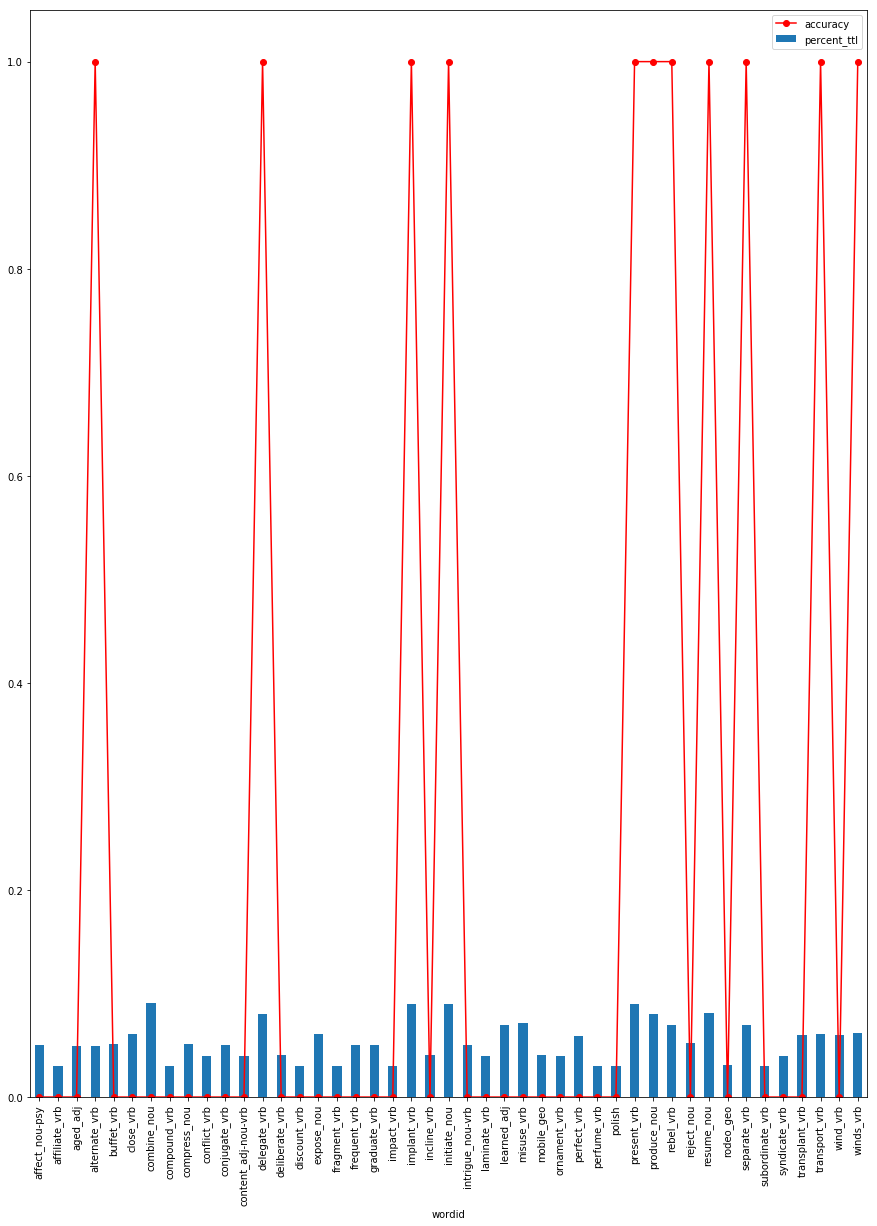

In [30]:
import matplotlib.pylab as plt
%matplotlib inline  

ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(15,20))

plt.show()

In [21]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
homs = hids_acc[hids_acc["percent_ttl"] < 0.2]['homograph'].tolist()
homs

['abuse',
 'abuses',
 'advocate',
 'affect',
 'affiliate',
 'aged',
 'aggregate',
 'alternate',
 'analyses',
 'approximate',
 'associate',
 'bass',
 'buffet',
 'close',
 'combine',
 'compound',
 'compress',
 'confines',
 'conflict',
 'conjugate',
 'conscript',
 'construct',
 'content',
 'contest',
 'convert',
 'convict',
 'correlate',
 'defect',
 'degenerate',
 'delegate',
 'deliberate',
 'discharge',
 'discount',
 'document',
 'dove',
 'escort',
 'excuse',
 'exploit',
 'export',
 'expose',
 'fragment',
 'frequent',
 'graduate',
 'impact',
 'implant',
 'implement',
 'incline',
 'increment',
 'initiate',
 'intrigue',
 'laminate',
 'learned',
 'minute',
 'misuse',
 'mobile',
 'nestle',
 'ornament',
 'perfect',
 'perfume',
 'polish',
 'present',
 'produce',
 'progress',
 'protest',
 'reading',
 'rebel',
 'record',
 'refuse',
 'reject',
 'rerelease',
 'resume',
 'retard',
 'rodeo',
 'sake',
 'separate',
 'subordinate',
 'syndicate',
 'transplant',
 'transport',
 'uses',
 'wind',
 'winds']

In [22]:
len(homs)

82

In [23]:
hids_acc['homograph'].nunique()

128

# Train and eval together

In [24]:
hids = pd.read_csv("C:/Users/jseal/Dev/dissertation/Data_Exploration/WHD/train_eval_hids.csv")

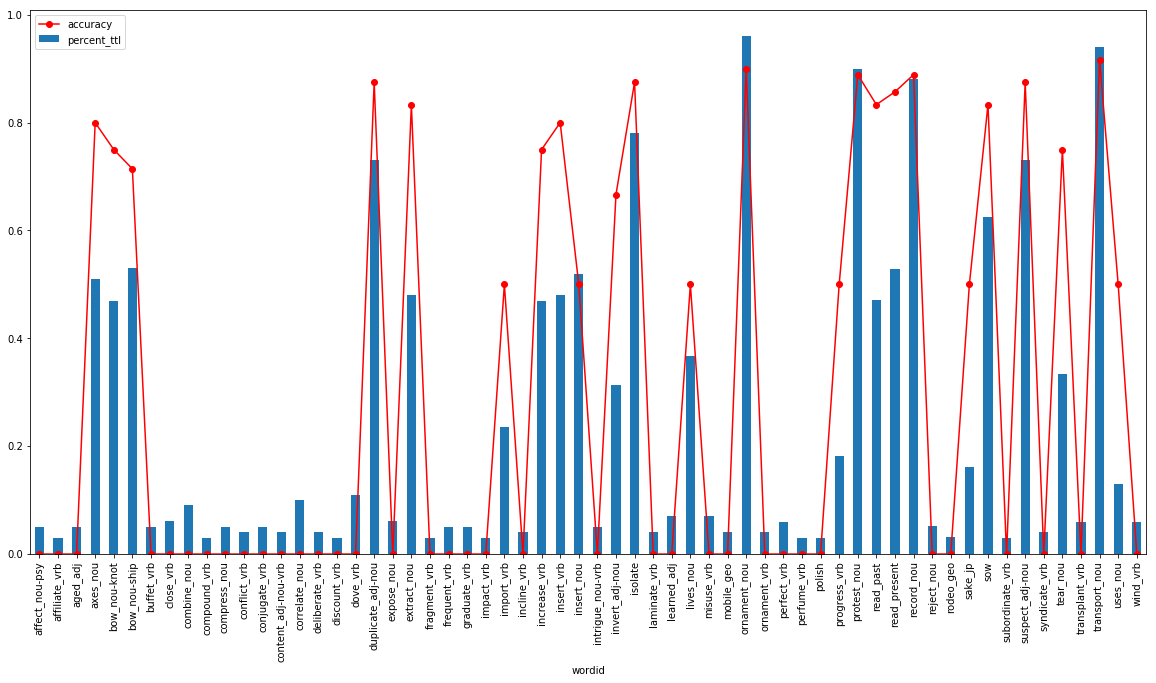

In [25]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
hids_acc = hids_acc[hids_acc['accuracy'] < 1.0]
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]
ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(20,10))

plt.show()

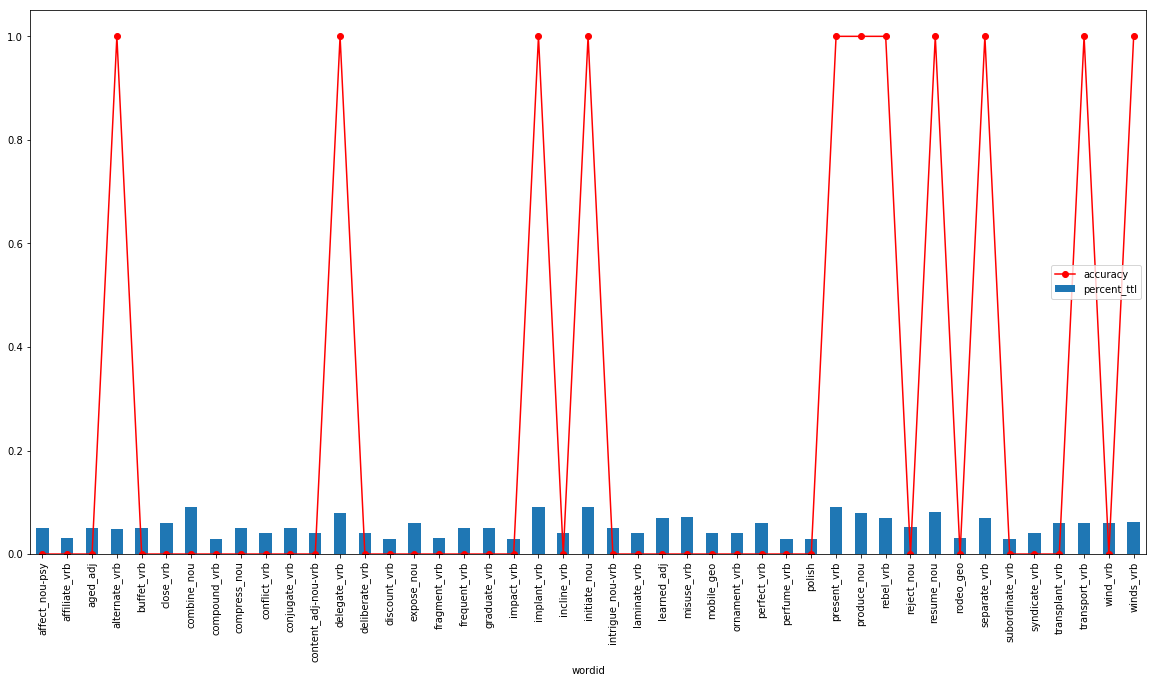

In [26]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
hids_acc = hids_acc[hids_acc['percent_ttl'] < 0.1]
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]
ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(20,10))

plt.show()

In [27]:
#WITH SEED_2
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = BertForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir=MODEL_OUTPUT,    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_2,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Step,Training Loss,Validation Loss,Accuracy Score,Balanced Accuracy Score
100,No log,0.613829,0.000000,0.000000
200,No log,0.393623,0.006686,0.004297
300,No log,0.254337,0.464339,0.287669
400,No log,0.124026,0.757801,0.489340
500,0.866103,0.083017,0.806092,0.531386
600,0.866103,0.063538,0.832838,0.583652
700,0.866103,0.052520,0.869242,0.649333
800,0.866103,0.043156,0.901189,0.683930
900,0.866103,0.041146,0.910104,0.732712
1000,0.051598,0.034106,0.930906,0.786137


C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


{'eval_loss': 0.020987413823604584,
 'eval_accuracy_score': 0.9561664190193165,
 'eval_balanced_accuracy_score': 0.8529357469787158,
 'epoch': 3.0}

In [28]:
#WITH SEED_3
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = BertForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir=MODEL_OUTPUT,    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_3,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Step,Training Loss,Validation Loss,Accuracy Score,Balanced Accuracy Score
100,No log,0.615880,0.000000,0.000000
200,No log,0.413146,0.000000,0.000000
300,No log,0.244105,0.583210,0.362069
400,No log,0.123343,0.738484,0.468079
500,0.866929,0.086042,0.810550,0.532268
600,0.866929,0.068433,0.836553,0.575127
700,0.866929,0.057020,0.872214,0.638554
800,0.866929,0.045146,0.890045,0.667468
900,0.866929,0.037329,0.911590,0.714137
1000,0.056428,0.036027,0.920505,0.737746


C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


{'eval_loss': 0.023963263258337975,
 'eval_accuracy_score': 0.9479940564635958,
 'eval_balanced_accuracy_score': 0.8279078451930014,
 'epoch': 3.0}

In [29]:
#WITH SEED_4
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = BertForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir=MODEL_OUTPUT,    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_4,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Step,Training Loss,Validation Loss,Accuracy Score,Balanced Accuracy Score
100,No log,0.614782,0.000000,0.000000
200,No log,0.399482,0.000000,0.000000
300,No log,0.249910,0.530461,0.325538
400,No log,0.125774,0.765973,0.487455
500,0.911007,0.083402,0.797177,0.526366
600,0.911007,0.067996,0.829123,0.566494
700,0.911007,0.058474,0.844725,0.595549
800,0.911007,0.049326,0.868499,0.643958
900,0.911007,0.041721,0.901189,0.703385
1000,0.054077,0.036173,0.910847,0.732416


C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


{'eval_loss': 0.023256022483110428,
 'eval_accuracy_score': 0.9531946508172363,
 'eval_balanced_accuracy_score': 0.8457804890422078,
 'epoch': 3.0}